In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import uncertainties as unc

In [2]:
def transfer(F, R):
    l = unc.ufloat(0.27058, 0.00046)
    C = l*25e-12/0.3048 
    RparallelC = (1/((1/20e6)**2+ (2*np.pi*F*(C+ 12.5e-12))**2)**0.5)
    return np.abs(RparallelC/(RparallelC+R))

def curveFit(f, ThermalNoise, f4):
    return (ThermalNoise  +f4*f**-4)

def excpectedThermal(F, R, T):
    return (4*1.380649e-23*T*R)**0.5
def thermalNoTransfer(R, T):
    return (4*1.380649e-23*T*R)**0.5

liquidN = thermalNoTransfer(1.09e6, 77)
print(liquidN)
l = unc.ufloat(0.27058, 0.00046)
C = l*25e-12/0.3048 
print(C)

6.808167758508893e-08
(2.219+/-0.004)e-11


In [3]:
def readData(fileName: str):
    data = pd.read_csv(fileName, sep="\t", header=None)
    return data[0], data[1]


In [4]:
_, uncsV = readData("uncs.txt")
five = uncsV[0:20]
hundred = uncsV[20:40]
thousand = uncsV[40:60]
uncPctFive = np.std(five)/np.mean(five)
uncPctHundred = np.std(hundred)/np.mean(hundred)
uncPctThousand = np.std(thousand)/np.mean(thousand)
print(uncPctFive, uncPctHundred, uncPctThousand)

0.06405111704962811 0.14300066995941668 0.20380011074927695


['data\\0Meg25GoodParam100msNoSync.txt', 'data\\0Meg5GoodParam100msNoSync.txt', 'data\\1MegGoodParam100msNoSync.txt', 'data\\cryoLowGood.txt', 'data\\cryoRoomGoodParam100msNoSync.txt']
[244648.0416156671+/-59.92608117886589, 500877.1055664111+/-25.10281605122557, 982361.2988799373+/-96.53284524267414, 984586.5829640572+/-96.97061378277276, 982650.9828009828+/-96.58977717945778]
Expected thermal noise
(6.3239+/-0.0013)e-08
Fit Thermal Noise 6.274131804768473e-08 +/- 2.1016680475187332e-09
Reduced Chi2 1.2007190069676545


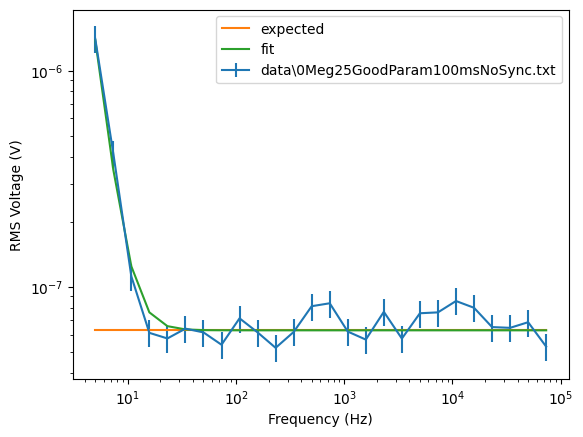

Expected thermal noise
(9.0486+/-0.0015)e-08
Fit Thermal Noise 8.50391272790123e-08 +/- 4.548870251617808e-09
Reduced Chi2 2.9667000736913014


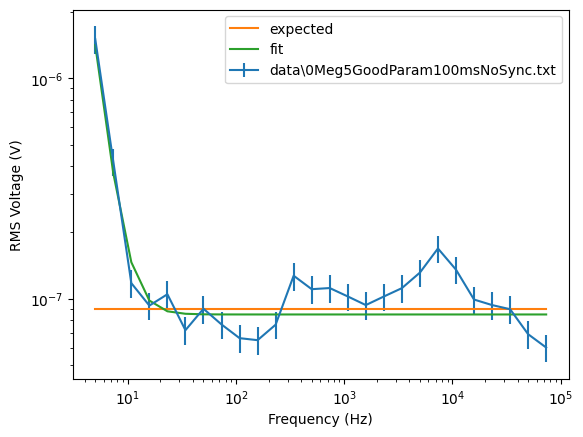

Expected thermal noise
(1.26722+/-0.00022)e-07
Fit Thermal Noise 1.268135995823007e-07 +/- 5.890974668038857e-09
Reduced Chi2 2.3056118003732453


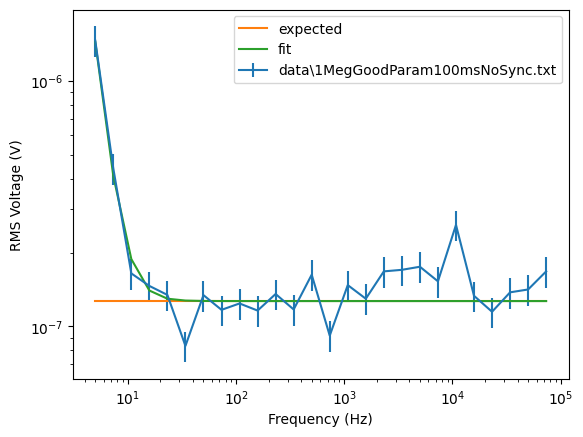

Expected thermal noise
(6.47+/-0.04)e-08
Fit Thermal Noise 9.665965796394359e-08 +/- 3.953035636750265e-09
Reduced Chi2 1.8013544039727174


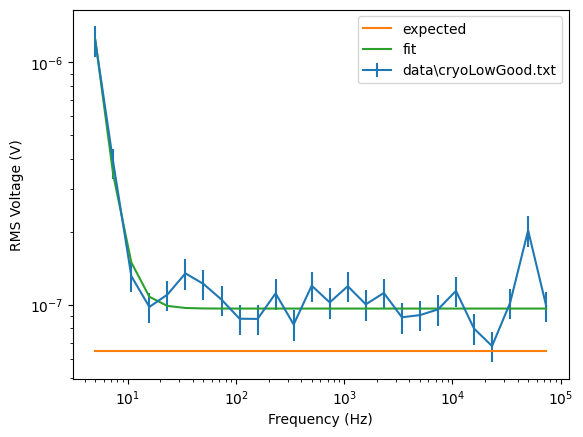

Expected thermal noise
(1.26591+/-0.00022)e-07
Fit Thermal Noise 1.1354025121407983e-07 +/- 7.1413150270713165e-09
Reduced Chi2 4.01883122490485


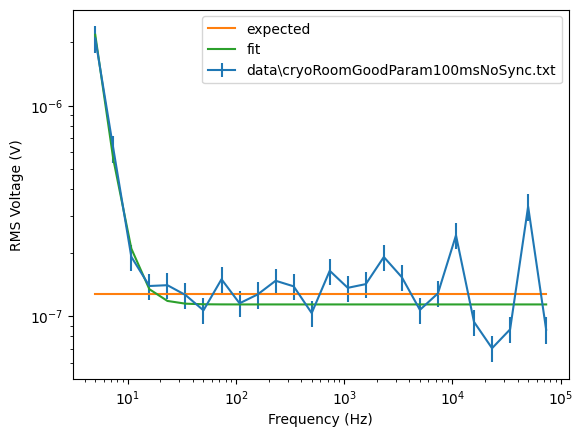

In [5]:
dataFiles = glob.glob("data/*")
print(dataFiles)
voltages = [unc.ufloat(408.5, 0.1)*1e-6, unc.ufloat(199.59, 0.01)*1e-6, unc.ufloat(101.78, 0.01)*1e-6,  unc.ufloat(101.55, 0.01)*1e-6,  unc.ufloat(101.75, 0.01)*1e-6]
resistances = []
for v in voltages:
    resistances.append((100-150*v)/(v))
print(resistances)
temps = [unc.ufloat(22.7+273.3, 0.1), unc.ufloat(22.7+273.3, 0.1), unc.ufloat(22.7+273.3, 0.1), unc.ufloat(77, 1),unc.ufloat(22.0+273.3, 0.1)]
# resistances = [unc.ufloat(250000, 1250), unc.ufloat(510000, 2550), unc.ufloat(1000000, 5000)]


for file, res, tmps in zip(dataFiles, resistances, temps):
    freqs, vs = readData(file)
    transferFunc = transfer(freqs, res)
    vcUnc = []
    for v in vs:
        vcUnc.append(unc.ufloat(v, v*uncPctHundred))
    vs = vcUnc/transferFunc
    vsNoUnc = []
    vsUncs = []
    for v in vs:
        vsNoUnc.append(v.n)
        vsUncs.append(v.s)
    temp = unc.ufloat(273.3+22.7, 0.1)
    expectedVal = thermalNoTransfer(res.n, tmps.n)
    expectedVal = np.ones_like(freqs)*expectedVal
    
    plt.errorbar(freqs, vsNoUnc, vsUncs, label=file)
    plt.plot(freqs, expectedVal, label="expected")
    print("Expected thermal noise")
    print(thermalNoTransfer(res, tmps))
    popt, pcov = curve_fit(curveFit, freqs, vsNoUnc, sigma=vsUncs, p0=[1e-9, expectedVal[0]])
    chi2 = np.sum(np.pow(np.array(vsNoUnc)-curveFit(freqs, *popt), 2)/np.array(vsUncs)**2)/(len(vsNoUnc)-2)
    print("Fit Thermal Noise", popt[0], "+/-", np.sqrt(pcov[0][0]))
    print("Reduced Chi2", chi2)
    plt.plot(freqs, curveFit(freqs, *popt), label="fit")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("RMS Voltage (V)")
    plt.legend()
    plt.xscale("log")
    plt.yscale("log")
    plt.show()